<center><h1 style ="font-size:300%; background-color:green; color:yellow; padding:50px;font-family:Garamond;"><b> Machine Translation Using Seq2Seq Model<b></h1></center>

<center><h1 style ="font-size:200%; background-color:green; color:yellow; padding:15px;font-family:Garamond;"><b> How It Work<b></h1></center>

- feed the embedding vectors for source sequences(German), to the encoder network, one word at time 
- Encode the input sentences into fixed dimention state vectors. At this step we get the hidden and cell states from the encoder LSTM, and feed it into Decoder LSTM.
- these states are regarded as initial states by decoder. additionally, it also hase the embedding vectors for for target words(English)
- Decode and output the translated sentences, one word at the time. in this step the output of the decoder is sent to softmax layer over the entire target vocabulery.

<center><h1 style ="font-size:300%; background-color:green; color:yellow; padding:15px;font-family:Garamond;"><b> Importing<b></h1></center>

In [1]:
import string 
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from keras.layers import Dense , LSTM ,Embedding , RepeatVector
from keras.models import load_model , Sequential 
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint 
from keras import optimizers 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline 
pd.set_option('display.max_colwidth',200)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# helper functions 

In [2]:
def load_data(file_name):
    file = open(file_name ,mode='rt' , encoding='utf-8')
    text =file.read()
    file.close()
    return text


def lines(text):
    text_line = text.strip().split('\n')
    final_text = [i.split('\t') for i in text_line]
    return final_text
    

In [3]:
file_name ="../input/bilingual-sentence-pairs/deu.txt"
# load data 
text = load_data(file_name)
# split data
data = lines(text)
data = np.array(data)

In [4]:
len(data)

227080

In [5]:
data = data[:50000]
len(data)

50000

In [6]:
#let's do some preprocessing on data 
# remove punctuations 

data[: , 0] = [s.translate(str.maketrans('' ,'', string.punctuation ) ) for s in data[:,0]] 
data[: , 1] = [s.translate(str.maketrans('','', string.punctuation )) for s in data[:,1]]

In [7]:
# convert all to lower case 

for i in range(len(data)):
    data[i,0] = data[i,0].lower()
    data[i,1] = data[i,1].lower()

In [8]:
data

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['im giving up smoking', 'ich höre mit dem rauchen auf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256952 (minshirui) & #407184 (MUIRIEL)'],
       ['im glad i was nearby', 'ich bin froh dass ich in der nähe war',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547219 (CK) & #3448316 (Pfirsichbaeumchen)'],
       ['im glad tom has gone', 'ich bin froh dass tom weg ist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547217 (CK) & #5299642 (Pfirsichbaeumchen)']],
      dtype='<U537')

- let's do some show 

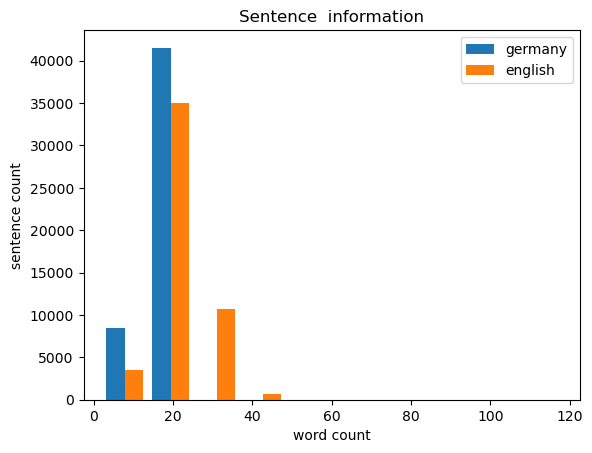

In [9]:
eng_length = []
ger_length= []


for i in range(len(data)):
    eng_length.append(len(data[i,0]))
    ger_length.append(len(data[i,1]))
    
    
    
df_show = pd.DataFrame({'eng':eng_length , 'ger':ger_length})
plt.title('Sentence  information')
plt.xlabel('word count')
plt.ylabel('sentence count')
plt.hist(df_show)
plt.legend(['germany','english'])
plt.show()

array([[<Axes: title={'center': 'eng'}>, <Axes: title={'center': 'ger'}>]],
      dtype=object)

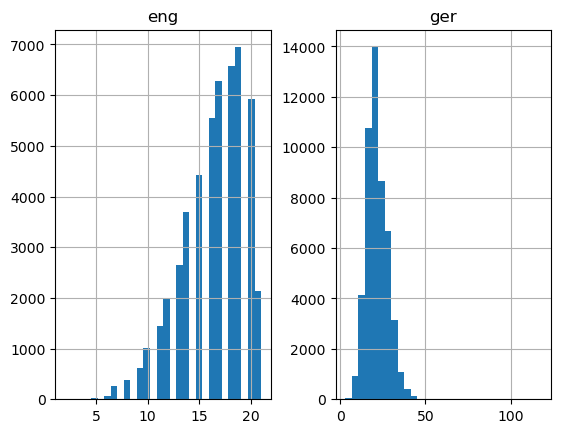

In [10]:
df_show.hist(bins =30)

In [11]:
# tokenize function 
def tokenize(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# encoding function 

def encoding(tokenizer , length , lines):
    encode_line = tokenizer.texts_to_sequences(lines)
    ## make padding to get all sentence with same length 
    pad_line = pad_sequences(encode_line , maxlen= length ,padding='post')
    return pad_line

In [12]:
# prepare english tokenizer 
eng_tokenizer = tokenize(data[:,0])
eng_vocab_size= len(eng_tokenizer.word_index) +1
# prepare german tokenizer 
ger_tokenizer = tokenize(data[:,1])
ger_vocab_size= len(ger_tokenizer.word_index) +1


eng_length =8
ger_length =8


In [13]:
# now we will split our data and  encode it to get it into the model 
from sklearn.model_selection import train_test_split

train_data , valid_data = train_test_split(data , test_size=0.1 ,shuffle=True , random_state=42)
# just remember that we want to translate from germany to english so input is ger and output is eng
X_train = encoding(ger_tokenizer , ger_length ,train_data[:,1])
X_valid = encoding(ger_tokenizer , ger_length ,valid_data[:,1])

y_train = encoding(eng_tokenizer , eng_length ,train_data[:,0])
y_valid = encoding(eng_tokenizer , eng_length ,valid_data[:,0])

<center><h1 style ="font-size:200%; background-color:green; color:yellow; padding:15px;font-family:Garamond;"><b> Model<b></h1></center>

In [14]:
def Build_Model(input_vocab , output_vocab , input_len ,output_len ,units):
    model = Sequential()
    model.add(Embedding(input_vocab , units ,input_length =input_len , mask_zero =True))
    model.add(LSTM(units))
    model.add(RepeatVector(output_len))
    model.add(LSTM(units , return_sequences =True))
    model.add(Dense(output_vocab , activation ='softmax'))
    return model

In [15]:
Translate_Model = Build_Model(ger_vocab_size ,eng_vocab_size , ger_length , eng_length ,512)
optim = optimizers.RMSprop(lr=1e-4)
# let's compile our model 
Translate_Model.compile(optimizer=optim , loss='sparse_categorical_crossentropy')

<center><h1 style ="font-size:200%; background-color:green; color:yellow; padding:15px;font-family:Garamond;"><b> Training <b></h1></center>

- Checkpoint save the minimum validation loss, so it's recomended to use.


In [16]:
file_name = 'Translate_Model.h1'
check_point = ModelCheckpoint(file_name,monitor='val_loss' ,verbose=1 ,save_best_only=True,mode='min')

history = Translate_Model.fit(X_train ,y_train.reshape(y_train.shape[0],y_train.shape[1],1)
                ,epochs=30,batch_size=512 ,validation_split=0.2 ,callbacks=[check_point] , verbose=1)


Epoch 1/30
70/71 [============================>.] - ETA: 0s - loss: 5.3622
Epoch 1: val_loss improved from inf to 3.67733, saving model to Translate_Model.h1
71/71 [==============================] - 31s 282ms/step - loss: 5.3549 - val_loss: 3.6773
Epoch 2/30
70/71 [============================>.] - ETA: 0s - loss: 3.4056
Epoch 2: val_loss improved from 3.67733 to 3.19158, saving model to Translate_Model.h1
71/71 [==============================] - 18s 250ms/step - loss: 3.4047 - val_loss: 3.1916
Epoch 3/30
70/71 [============================>.] - ETA: 0s - loss: 3.0555
Epoch 3: val_loss improved from 3.19158 to 2.98269, saving model to Translate_Model.h1
71/71 [==============================] - 19s 271ms/step - loss: 3.0550 - val_loss: 2.9827
Epoch 4/30
70/71 [============================>.] - ETA: 0s - loss: 2.9113
Epoch 4: val_loss improved from 2.98269 to 2.89504, saving model to Translate_Model.h1
71/71 [==============================] - 17s 248ms/step - loss: 2.9108 - val_loss: 2.8

<center><h1 style ="font-size:200%; background-color:green; color:yellow; padding:15px;font-family:Garamond;"><b> Train Result<b></h1></center>

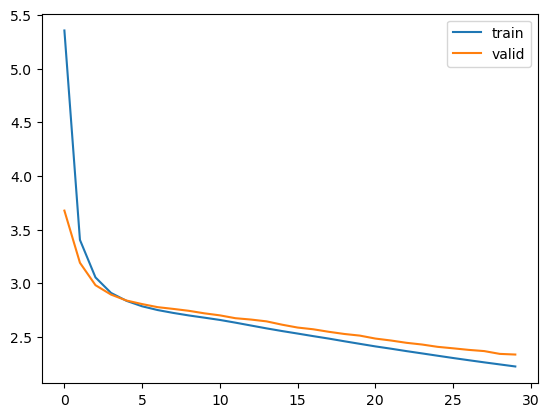

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.show()

<center><h1 style ="font-size:200%; background-color:green; color:yellow; padding:15px;font-family:Garamond;"><b> Test Model<b></h1></center>

In [18]:
# load trained model 
model = load_model(file_name)

In [19]:
# get prediction
preds = model.predict(X_valid.reshape((X_valid.shape[0] , X_valid.shape[1])))

157/157 [==============================] - 2s 5ms/step


In [20]:
preds

array([[[7.10899476e-05, 3.61569203e-03, 2.33638822e-03, ...,
         5.06683904e-08, 1.45017452e-07, 1.05002258e-07],
        [6.70391237e-05, 1.01225637e-01, 8.91747710e-04, ...,
         5.14259497e-08, 1.81455516e-06, 1.29336070e-06],
        [1.25328754e-03, 2.85680354e-01, 2.35740351e-03, ...,
         1.29555275e-07, 4.15423017e-07, 2.91875466e-07],
        ...,
        [9.95272100e-01, 2.07570018e-04, 7.65685684e-07, ...,
         8.81765327e-09, 2.64071459e-10, 2.45197501e-10],
        [9.99453247e-01, 1.20081377e-05, 1.26089375e-07, ...,
         4.02892109e-10, 8.46813852e-12, 7.25997387e-12],
        [9.99714434e-01, 4.14943042e-06, 6.13039646e-08, ...,
         1.44966053e-10, 2.96000767e-12, 2.35522040e-12]],

       [[1.73218810e-04, 4.44523757e-03, 8.16766697e-04, ...,
         1.59166177e-07, 3.53067719e-07, 2.86659571e-07],
        [2.34700696e-04, 3.24612111e-02, 2.51546269e-04, ...,
         2.30556253e-07, 5.68383939e-06, 4.60653200e-06],
        [7.02999812e-03, 